# Purpose


**2023-04-23**:<br>
<br> In this notebook we'll try an end-to-end process to get user<>subreddit table & training datay for a single campaign.


**DONE (previous steps)**
- Pull data:
    - User Time on Subreddit (save to local now, GCS in prod)
    - Get subreddit-level embeddings (save to local, GCS in prod)
- Reshape to get user-embeddings
    - For each ToSub file, get weighted embeddings for a user
        - Save user-level (weighted) embeddings to file
- Calculate ANN distance to input subreddit(s)
    - Create an index with ANNOY: per COUNTRY + subreddit
        - This way we ensure a minimum # of users per country
    - Load subreddit-embedding file
    - For each input target subreddit, get the ANN users
        - Try nearest 3 million users
    - Save raw ANN file

**This notebook:** <br>
(Quick version of these steps. We'll re-write when scaling up to multiple campaigns b/c the data will prob change)
- Load training data & labels for modeling (click/no click)
- Split into basic train/test fold
- Train base models on labeled data
    - Quick evaluation of model
- Run inference on all users & get proba() for all users & user<>sub combination
    - Save proba raw file
- Rank users by proba
    - Compare which users our model would say likely to click, but didn't even receive the PN
- Reshape user<>subreddit proba PN for bigQuery
    - Pick top 1 million users per subreddit


**TODO later / out of scope**
- Split training file into k-fold validation or train/test
- Train base models (do it a separate notebook)
- [later/tbd] Reshape ANN table & upload to BQ table
    - Reshape ANN file for BigQuery format
    - Upload ANN file to BQ for table creation




# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import gc
import logging
from logging import info
import os
from pathlib import Path
import json

import polars as pl
import numpy as np
import pandas as pd
import plotly
import seaborn as sns

from tqdm.auto import tqdm
import dask
import mlflow

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook
from typing import Tuple, Union

from subclu.models.nn_annoy import AnnoyIndex
from subclu.utils.eda import get_venn_sets2

from matplotlib_venn import venn2_unweighted

from google.cloud import bigquery
from subclu.pn_models import get_data


client = bigquery.Client()

print_lib_versions([bigquery, np, pd, pl, plotly, mlflow, subclu])

python		v 3.7.10
===
google.cloud.bigquery	v: 2.13.1
numpy		v: 1.19.5
pandas		v: 1.2.4
polars		v: 0.17.1
plotly		v: 5.11.0
mlflow		v: 1.16.0
subclu		v: 0.6.1


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Define local path for this model outputs

In [4]:
manual_model_timestamp = datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')
path_this_model = get_project_subfolder(
    f"data/models/pn_model/pn_manual_test_{manual_model_timestamp}"
)
Path.mkdir(path_this_model, parents=True, exist_ok=True)
print(path_this_model)

/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-04-24_210552


In [5]:
path_ann_df = Path("/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-04-19_172950")
f_ann_df = str(path_ann_df / "df_ann_distance_to_target-10533999_5.parquet")

In [6]:
!ls $path_ann_df

df_ann_distance_to_target-10533999_5.parquet
df_ann_distance_to_target-10533999_6.parquet
df_subreddit_embeddings_wide-236115_102.parquet
df_user_embedding-2023-04-19_1841-10533999_by_101.parquet


# Define key inputs
Use these throughout the process to filter/target specific subreddits, geos, & users

In [7]:
l_target_subreddits = ['de']

# We would want to add an automated way to pick these ANN subs, but look them up manually for now
l_target_ann_subreddits = ['fragreddit', 'ich_iel']

l_target_geos = ['DE']

# Load & reshape data

## Load training data from BQ

Label info:
- send, receive, click [Click is the target, but we need sends & receives so that we can select only users who received or clicked]

Selected features v0:
- TODO: num of subreddits in ToS calculation
- views, consumes, etc. in target subreddit
- User latest country
- user<>subreddit distances (currently in a local file, not in BQ)

features to add for v1:
- target subreddit percentage visits from different geos (wide version of `community_score` table)
- target subreddit primary language
- user primary language(s)

#### Features to add maybe way later(?)
`Subscription` tables expire after 90 days... (sigh)
<br>So we'll have imperfect data for training models before 2023-02
<br>Maybe we should just exclude it for historical campaigns and only add it going forward?


**NOTE / TODO(djb)**
- For this notebook I'll only train on user who RECEIVED the PN
- But in the future we might want to model whether someone will even receive the PN (saves us from wasting PNs on users not likely to be active... unless the goal is to re-activate dormant users)

In [8]:
%%time
%%bigquery df_train_raw --project data-science-prod-218515 

-- Select trainig data AND users to train PN model
DECLARE PT_FEATURES DATE DEFAULT "2022-12-01";
DECLARE PT_WINDOW_START DATE DEFAULT PT_FEATURES - 7;

WITH subreddit_per_user_count AS (
    SELECT
        tos.user_id
        , COUNT(DISTINCT subreddit_id) AS tos_sub_count
    FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_tos_30_pct_20230418` AS tos
    GROUP BY 1
)
, post_consumes_agg AS (
    SELECT
        user_id
        , SUM(num_post_consumes) AS num_post_consumes
        , SUM(num_post_consumes_home) AS num_post_consumes_home
        , SUM(num_post_consumes_community) AS num_post_consumes_community
        , SUM(num_post_consumes_post_detail) AS num_post_consumes_post_detail
        , SUM(IF(app_name = 'ios', num_post_consumes, 0)) AS num_post_consumes_ios
        , SUM(IF(app_name = 'android', num_post_consumes, 0)) AS num_post_consumes_android
        , SUM(num_post_consumes_nsfw) AS num_post_consumes_nsfw
        , SAFE_DIVIDE(SUM(num_post_consumes_nsfw), SUM(num_post_consumes)) AS pct_post_consumes_nsfw
        -- , SUM(num_post_consumes_sfw) AS num_post_consumes_sfw
    FROM `data-prod-165221.video.post_consumes_30d_agg`
    WHERE DATE(pt) = PT_FEATURES
    GROUP BY 1
)
, core_train_info AS (
    SELECT
        -- Need to fill cases where user_id is missing from new selection criteria
        COALESCE(act.user_id, f.user_id) AS user_id
        , COALESCE(act.target_subreddit, f.subreddit_name) AS subreddit_name
        , COALESCE(act.send, 0) AS send
        , COALESCE(act.receive, 0) AS receive
        , COALESCE(act.click, 0) AS click
        
        -- , f.subreddit_id
        -- , f.subreddit_name AS view_sub_name
        , f.* EXCEPT(pt, pt_window_start, user_id, subreddit_name, subreddit_id)

    FROM (
        SELECT *
        FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_20230418`
        WHERE subreddit_name = 'de'
    ) AS f
        FULL OUTER JOIN `reddit-employee-datasets.david_bermejo.pn_training_data_test` AS act
            ON f.user_id = act.user_id
)
, user_actions_t7 AS (
    SELECT
      user_id,
      COUNT(receive_endpoint_timestamp) user_receives_pn_t7,
      COUNT(click_endpoint_timestamp) user_clicks_pn_t7,
      COUNT(
        CASE
          WHEN notification_type='lifecycle_post_suggestions' 
            THEN click_endpoint_timestamp
          ELSE NULL
        END
    ) user_clicks_trnd_t7
    FROM `data-prod-165221.channels.push_notification_events`
    WHERE
        DATE(pt) BETWEEN PT_WINDOW_START AND PT_FEATURES
        AND NOT REGEXP_CONTAINS(notification_type, "email")
        AND receive_endpoint_timestamp IS NOT NULL
  GROUP BY user_id 
)

SELECT
    -- Need to fill cases where user_id is missing from new selection criteria
    ct.user_id
    , ct.subreddit_name
    , ct.send
    , ct.receive
    , ct.click
    , COALESCE(tos.tos_sub_count, 0) AS tos_sub_count
    , COALESCE(sv.feature_value, 0) AS screen_view_count_14d
    , cl.legacy_user_cohort
    , pna.* EXCEPT(user_id)
    , co.* EXCEPT(user_id)
    , ct.* EXCEPT(user_id, subreddit_name, send, receive, click)

FROM core_train_info AS ct
    -- Get count of subs in ToS
    LEFT JOIN subreddit_per_user_count AS tos
        ON ct.user_id = tos.user_id
    -- Recent PN activity 
    LEFT JOIN user_actions_t7 AS pna
        ON ct.user_id = pna.user_id
    -- Get view counts (all subreddits)
    LEFT JOIN (
        SELECT entity_id, feature_value
        FROM `data-prod-165221.user_feature_platform.screen_views_count_over_14_days_v1` 
        WHERE DATE(pt) = PT_FEATURES
    ) AS sv
        ON ct.user_id = sv.entity_id
    -- USER cohort, Legacy
    LEFT JOIN (
        SELECT user_id, legacy_user_cohort
        FROM `data-prod-165221.attributes_platform.user_rolling_legacy_user_cohorts` 
        WHERE DATE(pt) = PT_FEATURES
    ) AS cl
        ON ct.user_id = cl.user_id
    -- USER consumes
    LEFT JOIN post_consumes_agg AS co
        ON ct.user_id = co.user_id

WHERE ct.receive = 1

ORDER BY click DESC, tos_sub_count DESC
;

Downloading: 100%|██████████| 253584/253584 [00:01<00:00, 148021.84rows/s]

CPU times: user 1.18 s, sys: 267 ms, total: 1.45 s
Wall time: 1min 30s


In [9]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253584 entries, 0 to 253583
Data columns (total 28 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   user_id                              253584 non-null  object 
 1   subreddit_name                       253584 non-null  object 
 2   send                                 253584 non-null  int64  
 3   receive                              253584 non-null  int64  
 4   click                                253584 non-null  int64  
 5   tos_sub_count                        253584 non-null  int64  
 6   screen_view_count_14d                253584 non-null  int64  
 7   legacy_user_cohort                   170906 non-null  object 
 8   user_receives_pn_t7                  247593 non-null  float64
 9   user_clicks_pn_t7                    247593 non-null  float64
 10  user_clicks_trnd_t7                  247593 non-null  float64
 11  num_post_cons

In [10]:
counts_describe(df_train_raw[['user_id', 'subreddit_name',  'click', 'subscribed']])

,dtype,count,unique,unique-percent,null-count,null-percent
user_id,object,"253,584","253,583",100.00%,0,0.00%
subreddit_name,object,"253,584",1,0.00%,0,0.00%
click,int64,"253,584",2,0.00%,0,0.00%
subscribed,float64,"181,406",1,0.00%,"72,178",28.46%


Unclear where these duplicates came from, but for now we'll remove them.

TODO(djb): Will go back to debug user-generation later

In [11]:
(
    df_train_raw[df_train_raw.duplicated(subset='user_id', keep=False)]
    .sort_values(by=['user_id'])
)

,user_id,subreddit_name,send,receive,click,tos_sub_count,screen_view_count_14d,legacy_user_cohort,user_receives_pn_t7,user_clicks_pn_t7,user_clicks_trnd_t7,num_post_consumes,num_post_consumes_home,num_post_consumes_community,num_post_consumes_post_detail,num_post_consumes_ios,num_post_consumes_android,num_post_consumes_nsfw,pct_post_consumes_nsfw,geo_country_code,subscribed,user_in_actual_but_missing_from_new,view_and_consume_unique_count,consume_unique_count,view_count,consume_count,consume_ios_count,consume_android_count
56601,t2_6yxrzyy,de,1,1,0,121,21,core,104.0,2.0,2.0,8806.0,1351.0,3198.0,0.0,8806.0,0.0,185.0,0.021008,DE,0.0,0.0,744.0,742.0,380.0,2216.0,2216.0,0.0
56602,t2_6yxrzyy,de,1,1,0,121,21,core,104.0,2.0,2.0,8806.0,1351.0,3198.0,0.0,8806.0,0.0,185.0,0.021008,DE,0.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0


In [12]:
%%time

df_train_raw = df_train_raw.drop_duplicates(subset=['user_id'], keep=False)
df_train_raw.shape

CPU times: user 80.6 ms, sys: 20.1 ms, total: 101 ms
Wall time: 100 ms


(253582, 28)

In [13]:
counts_describe(df_train_raw[['user_id', 'subreddit_name', 'click', 'subscribed']])

,dtype,count,unique,unique-percent,null-count,null-percent
user_id,object,"253,582","253,582",100.00%,0,0.00%
subreddit_name,object,"253,582",1,0.00%,0,0.00%
click,int64,"253,582",2,0.00%,0,0.00%
subscribed,float64,"181,404",1,0.00%,"72,178",28.46%


In [16]:
assert len(df_train_raw) == df_train_raw['user_id'].nunique()

In [17]:
df_train_raw.head()

,user_id,subreddit_name,send,receive,click,tos_sub_count,screen_view_count_14d,legacy_user_cohort,user_receives_pn_t7,user_clicks_pn_t7,user_clicks_trnd_t7,num_post_consumes,num_post_consumes_home,num_post_consumes_community,num_post_consumes_post_detail,num_post_consumes_ios,num_post_consumes_android,num_post_consumes_nsfw,pct_post_consumes_nsfw,geo_country_code,subscribed,user_in_actual_but_missing_from_new,view_and_consume_unique_count,consume_unique_count,view_count,consume_count,consume_ios_count,consume_android_count
0,t2_9zijedm0,de,1,1,1,1013,21,core,58.0,0.0,0.0,29743.0,2007.0,11541.0,0.0,0.0,29743.0,19575.0,0.658138,DE,0.0,0.0,49.0,46.0,8.0,124.0,0.0,124.0
1,t2_is69c8yu,de,1,1,1,954,21,core,52.0,32.0,27.0,21346.0,4375.0,3640.0,0.0,0.0,21346.0,17080.0,0.800150,DE,0.0,0.0,1.0,1.0,2.0,6.0,0.0,6.0
2,t2_md0rajcx,de,1,1,1,918,21,core,156.0,24.0,0.0,32850.0,18765.0,3873.0,0.0,0.0,32850.0,29623.0,0.901766,DE,0.0,0.0,474.0,474.0,72.0,1230.0,0.0,1230.0
3,t2_tahcrp1q,de,1,1,1,829,21,core,1.0,0.0,0.0,15246.0,2466.0,620.0,0.0,0.0,15246.0,13003.0,0.852879,DE,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
4,t2_hqb68gin,de,1,1,1,779,21,core,105.0,23.0,6.0,23333.0,3805.0,7065.0,0.0,0.0,23333.0,18981.0,0.813483,DE,0.0,0.0,20.0,20.0,2.0,50.0,0.0,50.0


## Append user<>subreddit distances 

In [18]:
%%time

df_ann = pl.read_parquet(
    f_ann_df,
    columns=['subreddit_name', 'user_id', 'cosine_similarity'],
)
df_ann.shape

CPU times: user 531 ms, sys: 202 ms, total: 733 ms
Wall time: 362 ms


(10533999, 3)

In [19]:
(
    df_ann
    .sample(n=int(1e6))
    [['cosine_similarity']]
    .describe()
)

describe,cosine_similarity
str,f64
"""count""",1e6
"""null_count""",0.0
"""mean""",0.454757
"""std""",0.190074
"""min""",-0.04931
"""max""",1.0
"""median""",0.436497


In [20]:
%%time

df_train = (
    df_train_raw
    # .drop(['subreddit_id', 'view_sub_name', ], axis=1)
    [df_train_raw['receive'] == 1]
    .merge(
        df_ann.to_pandas(),
        how='left',
        on=['user_id', 'subreddit_name'],
    ) 
)

df_train.shape

CPU times: user 12.7 s, sys: 1.41 s, total: 14.1 s
Wall time: 14.1 s


(253582, 29)

# Some EDA

In [21]:
counts_describe(df_train)

,dtype,count,unique,unique-percent,null-count,null-percent
user_id,object,"253,582","253,582",100.00%,0,0.00%
subreddit_name,object,"253,582",1,0.00%,0,0.00%
send,int64,"253,582",1,0.00%,0,0.00%
receive,int64,"253,582",1,0.00%,0,0.00%
click,int64,"253,582",2,0.00%,0,0.00%
tos_sub_count,int64,"253,582",816,0.32%,0,0.00%
screen_view_count_14d,int64,"253,582",21,0.01%,0,0.00%
legacy_user_cohort,object,"170,904",4,0.00%,"82,678",32.60%
user_receives_pn_t7,float64,"247,591",903,0.36%,"5,991",2.36%
user_clicks_pn_t7,float64,"247,591",240,0.10%,"5,991",2.36%


### All users in original campaign are in new data selection

However, this is only because I forced them into the new selection. It's possible they had views over 1 month ago OR no views at all (if the selection was based on subscription).

In [22]:
value_counts_and_pcts(
    df_train['user_in_actual_but_missing_from_new'].fillna(-1),
    sort_index=True,
    top_n=None,
)

,user_in_actual_but_missing_from_new-count,user_in_actual_but_missing_from_new-percent,user_in_actual_but_missing_from_new-pct_cumulative_sum
0.0,"181,404",71.5%,71.5%
-1.0,"72,178",28.5%,100.0%


### Click (CTR)
Since we're looking only at user that RECEIVED the PN, this CTR should be the same as the one computed in the overall dashboard

In [23]:
value_counts_and_pcts(
    df_train,
    ['click'],
    sort_index=True,
    top_n=None,
)

,count,percent,cumulative_percent
click,,,
1,"13,226",5.2%,5.2%
0,"240,356",94.8%,100.0%


### Clicks by Geo

In [25]:
df_geo_receive_counts = (
    df_train
    .groupby(['geo_country_code'], as_index=False)
    .agg(
        **{'receive_count': ('receive', 'count')}
    )
)

df_geos_over_200 = (
    df_geo_receive_counts
    [df_geo_receive_counts['receive_count'] >= 200]  
)
display(df_geos_over_200)

df_click_by_geo = value_counts_and_pcts(
    df_train,
    ['geo_country_code', 'click'],
    sort_index=True,
    sort_index_ascending=True,
    reset_index=True,
    top_n=None,
    return_df=True
)


style_df_numeric(
    df_click_by_geo
    [(
        (df_click_by_geo['geo_country_code'].isin(df_geos_over_200['geo_country_code'])) |
        (df_click_by_geo['geo_country_code'] == 'null')
    )]
    .drop('cumulative_percent', axis=1)
    .set_index(['geo_country_code', 'click'])
    ,
    l_bar_simple=['count', 'percent'],
)


,geo_country_code,receive_count
4,AT,850
20,CH,633
29,DE,174807
37,ES,245
41,FR,240
42,GB,478
93,NL,564
127,US,653


### Clicks - cohort

In [30]:
value_counts_and_pcts(
    (
        df_train
        .assign(legacy_user_cohort=df_train['legacy_user_cohort'].fillna('_missing_'))
    ),
    ['legacy_user_cohort', 'click'],
    sort_index=True,
    top_n=None,
)


In [28]:
value_counts_and_pcts(
    (
        df_train
        .assign(legacy_user_cohort=df_train['legacy_user_cohort'].fillna('_missing_'))
        [df_train['click'] == 1]
    ),
    ['legacy_user_cohort', 'click'],
    # sort_index=True,
    top_n=None,
)

,,count,percent,cumulative_percent
legacy_user_cohort,click,,,
core,1,"11,767",89.0%,89.0%
_missing_,1,"1,129",8.5%,97.5%
casual,1,244,1.8%,99.3%
resurrected,1,69,0.5%,99.9%
new,1,17,0.1%,100.0%


### Clicks - other cuts

In [31]:
df_train.head()

,user_id,subreddit_name,send,receive,click,tos_sub_count,screen_view_count_14d,legacy_user_cohort,user_receives_pn_t7,user_clicks_pn_t7,user_clicks_trnd_t7,num_post_consumes,num_post_consumes_home,num_post_consumes_community,num_post_consumes_post_detail,num_post_consumes_ios,num_post_consumes_android,num_post_consumes_nsfw,pct_post_consumes_nsfw,geo_country_code,subscribed,user_in_actual_but_missing_from_new,view_and_consume_unique_count,consume_unique_count,view_count,consume_count,consume_ios_count,consume_android_count,cosine_similarity
0,t2_9zijedm0,de,1,1,1,1013,21,core,58.0,0.0,0.0,29743.0,2007.0,11541.0,0.0,0.0,29743.0,19575.0,0.658138,DE,0.0,0.0,49.0,46.0,8.0,124.0,0.0,124.0,0.355278
1,t2_is69c8yu,de,1,1,1,954,21,core,52.0,32.0,27.0,21346.0,4375.0,3640.0,0.0,0.0,21346.0,17080.0,0.800150,DE,0.0,0.0,1.0,1.0,2.0,6.0,0.0,6.0,0.320875
2,t2_md0rajcx,de,1,1,1,918,21,core,156.0,24.0,0.0,32850.0,18765.0,3873.0,0.0,0.0,32850.0,29623.0,0.901766,DE,0.0,0.0,474.0,474.0,72.0,1230.0,0.0,1230.0,0.600328
3,t2_tahcrp1q,de,1,1,1,829,21,core,1.0,0.0,0.0,15246.0,2466.0,620.0,0.0,0.0,15246.0,13003.0,0.852879,DE,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.150692
4,t2_hqb68gin,de,1,1,1,779,21,core,105.0,23.0,6.0,23333.0,3805.0,7065.0,0.0,0.0,23333.0,18981.0,0.813483,DE,0.0,0.0,20.0,20.0,2.0,50.0,0.0,50.0,0.323700


In [137]:
l_cols_to_bin_ = [
    'tos_sub_count', 'screen_view_count_14d',
    'user_receives_pn_t7', 'user_clicks_pn_t7', 'user_clicks_trnd_t7',
    
    'num_post_consumes', 'num_post_consumes_community',
    'pct_post_consumes_nsfw',
    
    'view_and_consume_unique_count',
    'cosine_similarity'
]

for c_to_bin_ in l_cols_to_bin_:
    c_new_ = f"{c_to_bin_}_bin"
    print(f"\n== {c_to_bin_} ==")
    fill_na_val = -2
    null_count_ = df_train[c_to_bin_].isnull().sum()
    display(style_df_numeric(df_train[c_to_bin_].describe().to_frame().T))
    
    if null_count_ > 1:
        # min_val_ = min([fill_na_val, df_train[c_to_bin_].min()])
        display(style_df_numeric(df_train[c_to_bin_].fillna(fill_na_val).describe().to_frame().T))
    else:
        # min_val_ = df_train[c_to_bin_].min()
        pass
    

    # Try to make better bins... ?
#     max_val_ = df_train[c_to_bin_].max()
        
#     if min_val_ < 0:
#         bins_ = 
#     else:
#         bins_ = 
    
    display(
        value_counts_and_pcts(
            (
                df_train
                .assign(
                    **{
                        c_new_: pd.qcut(
                            df_train[c_to_bin_].fillna(fill_na_val),
                            q=9,
                            duplicates='drop',
                        )
                    }
                )
                [df_train['click'] == 1]
            ),
            [c_new_, 'click'],
            sort_index=True,
            top_n=None,
            pct_digits=3,
        )
    )



== tos_sub_count ==


,count,mean,std,min,25%,50%,75%,max
tos_sub_count,"253,582",67.63,81.36,0.00,10.00,41.00,96.00,"1,469.00"


,,count,percent,cumulative_percent
tos_sub_count_bin,click,,,
"(160.0, 1469.0]",1,"1,797",13.587%,13.587%
"(105.0, 160.0]",1,"1,861",14.071%,27.658%
"(73.0, 105.0]",1,"1,831",13.844%,41.502%
"(50.0, 73.0]",1,"1,926",14.562%,56.064%
"(33.0, 50.0]",1,"1,826",13.806%,69.870%
"(19.0, 33.0]",1,"1,538",11.629%,81.499%
"(8.0, 19.0]",1,"1,354",10.237%,91.736%
"(2.0, 8.0]",1,846,6.396%,98.132%
"(-0.001, 2.0]",1,247,1.868%,100.000%



== screen_view_count_14d ==


,count,mean,std,min,25%,50%,75%,max
screen_view_count_14d,"253,582",14.02,7.70,0.00,7.00,18.00,21.00,21.00


,,count,percent,cumulative_percent
screen_view_count_14d_bin,click,,,
"(19.0, 21.0]",1,"9,263",70.036%,70.036%
"(16.0, 19.0]",1,"1,921",14.524%,84.561%
"(11.0, 16.0]",1,"1,110",8.393%,92.953%
"(6.0, 11.0]",1,532,4.022%,96.976%
"(2.0, 6.0]",1,260,1.966%,98.941%
"(-0.001, 2.0]",1,140,1.059%,100.000%



== user_receives_pn_t7 ==


,count,mean,std,min,25%,50%,75%,max
user_receives_pn_t7,"247,591",46.76,74.30,1.00,31.00,33.00,56.00,"9,137.00"


,count,mean,std,min,25%,50%,75%,max
user_receives_pn_t7,"253,582",45.61,73.79,-2.00,31.00,33.00,54.00,"9,137.00"


,,count,percent,cumulative_percent
user_receives_pn_t7_bin,click,,,
"(73.0, 9137.0]",1,"2,358",17.829%,17.829%
"(60.0, 73.0]",1,"1,694",12.808%,30.637%
"(38.0, 60.0]",1,"1,849",13.980%,44.617%
"(33.0, 38.0]",1,"1,172",8.861%,53.478%
"(32.0, 33.0]",1,956,7.228%,60.706%
"(31.0, 32.0]",1,"1,212",9.164%,69.870%
"(12.0, 31.0]",1,"1,798",13.594%,83.464%
"(-2.001, 12.0]",1,"2,187",16.536%,100.000%



== user_clicks_pn_t7 ==


,count,mean,std,min,25%,50%,75%,max
user_clicks_pn_t7,"247,591",3.59,11.61,0.00,0.00,0.00,3.00,"2,008.00"


,count,mean,std,min,25%,50%,75%,max
user_clicks_pn_t7,"253,582",3.46,11.51,-2.00,0.00,0.00,3.00,"2,008.00"


,,count,percent,cumulative_percent
user_clicks_pn_t7_bin,click,,,
"(10.0, 2008.0]",1,"6,565",49.637%,49.637%
"(4.0, 10.0]",1,"2,522",19.069%,68.706%
"(1.0, 4.0]",1,"1,675",12.664%,81.370%
"(0.0, 1.0]",1,883,6.676%,88.046%
"(-2.001, 0.0]",1,"1,581",11.954%,100.000%



== user_clicks_trnd_t7 ==


,count,mean,std,min,25%,50%,75%,max
user_clicks_trnd_t7,"247,591",2.34,5.03,0.00,0.00,0.00,2.00,53.00


,count,mean,std,min,25%,50%,75%,max
user_clicks_trnd_t7,"253,582",2.24,5.01,-2.00,0.00,0.00,2.00,53.00


,,count,percent,cumulative_percent
user_clicks_trnd_t7_bin,click,,,
"(7.0, 53.0]",1,"6,178",46.711%,46.711%
"(2.0, 7.0]",1,"2,445",18.486%,65.197%
"(1.0, 2.0]",1,513,3.879%,69.076%
"(0.0, 1.0]",1,519,3.924%,73.000%
"(-2.001, 0.0]",1,"3,571",27.000%,100.000%



== num_post_consumes ==


,count,mean,std,min,25%,50%,75%,max
num_post_consumes,"247,440","5,607.43","7,790.86",0.00,317.00,"2,423.00","8,026.00","159,591.00"


,count,mean,std,min,25%,50%,75%,max
num_post_consumes,"253,582","5,471.56","7,744.10",-2.00,252.00,"2,251.00","7,819.00","159,591.00"


,,count,percent,cumulative_percent
num_post_consumes_bin,click,,,
"(14546.0, 159591.0]",1,"2,243",16.959%,16.959%
"(8819.0, 14546.0]",1,"2,069",15.643%,32.602%
"(5414.0, 8819.0]",1,"1,959",14.812%,47.414%
"(3103.333, 5414.0]",1,"1,807",13.662%,61.077%
"(1564.667, 3103.333]",1,"1,591",12.029%,73.106%
"(633.0, 1564.667]",1,"1,357",10.260%,83.366%
"(174.0, 633.0]",1,"1,096",8.287%,91.653%
"(14.0, 174.0]",1,825,6.238%,97.891%
"(-2.001, 14.0]",1,279,2.109%,100.000%



== num_post_consumes_community ==


,count,mean,std,min,25%,50%,75%,max
num_post_consumes_community,"247,440","1,048.39","2,078.54",0.00,40.00,305.00,"1,133.00","112,064.00"


,count,mean,std,min,25%,50%,75%,max
num_post_consumes_community,"253,582","1,022.95","2,059.56",-2.00,31.00,284.00,"1,099.00","112,064.00"


,,count,percent,cumulative_percent
num_post_consumes_community_bin,click,,,
"(2566.0, 112064.0]",1,"1,937",14.645%,14.645%
"(1278.0, 2566.0]",1,"1,892",14.305%,28.951%
"(709.0, 1278.0]",1,"1,848",13.972%,42.923%
"(391.0, 709.0]",1,"1,859",14.056%,56.979%
"(200.0, 391.0]",1,"1,736",13.126%,70.104%
"(84.0, 200.0]",1,"1,536",11.613%,81.718%
"(18.0, 84.0]",1,"1,252",9.466%,91.184%
"(0.0, 18.0]",1,663,5.013%,96.197%
"(-2.001, 0.0]",1,503,3.803%,100.000%



== pct_post_consumes_nsfw ==


,count,mean,std,min,25%,50%,75%,max
pct_post_consumes_nsfw,"235,441",0.26,0.31,0.00,0.02,0.08,0.46,1.00


,count,mean,std,min,25%,50%,75%,max
pct_post_consumes_nsfw,"253,582",0.09,0.66,-2.00,0.02,0.07,0.40,1.00


,,count,percent,cumulative_percent
pct_post_consumes_nsfw_bin,click,,,
"(0.787, 1.0]",1,467,3.531%,3.531%
"(0.49, 0.787]",1,857,6.480%,10.011%
"(0.203, 0.49]",1,"1,653",12.498%,22.509%
"(0.0919, 0.203]",1,"1,912",14.456%,36.965%
"(0.0502, 0.0919]",1,"2,084",15.757%,52.722%
"(0.0295, 0.0502]",1,"2,024",15.303%,68.025%
"(0.0111, 0.0295]",1,"2,239",16.929%,84.954%
"(0.0, 0.0111]",1,962,7.274%,92.227%
"(-2.001, 0.0]",1,"1,028",7.773%,100.000%



== view_and_consume_unique_count ==


,count,mean,std,min,25%,50%,75%,max
view_and_consume_unique_count,"181,404",92.70,228.05,0.00,2.00,9.00,58.00,"2,864.00"


,count,mean,std,min,25%,50%,75%,max
view_and_consume_unique_count,"253,582",65.74,197.56,-2.00,-2.00,3.00,24.00,"2,864.00"


,,count,percent,cumulative_percent
view_and_consume_unique_count_bin,click,,,
"(148.0, 2864.0]",1,"2,237",16.914%,16.914%
"(34.0, 148.0]",1,"2,026",15.318%,32.232%
"(11.0, 34.0]",1,"1,637",12.377%,44.609%
"(4.0, 11.0]",1,"1,619",12.241%,56.850%
"(2.0, 4.0]",1,"1,033",7.810%,64.661%
"(1.0, 2.0]",1,770,5.822%,70.482%
"(-2.001, 1.0]",1,"3,904",29.518%,100.000%



== cosine_similarity ==


,count,mean,std,min,25%,50%,75%,max
cosine_similarity,"236,728",0.53,0.22,-0.04,0.37,0.50,0.69,1.00


,count,mean,std,min,25%,50%,75%,max
cosine_similarity,"253,582",0.37,0.67,-2.00,0.33,0.48,0.67,1.00


,,count,percent,cumulative_percent
cosine_similarity_bin,click,,,
"(0.865, 1.0]",1,"2,391",18.078%,18.078%
"(0.711, 0.865]",1,"2,062",15.591%,33.669%
"(0.586, 0.711]",1,"1,679",12.695%,46.363%
"(0.51, 0.586]",1,"1,590",12.022%,58.385%
"(0.452, 0.51]",1,"1,683",12.725%,71.110%
"(0.391, 0.452]",1,"1,527",11.545%,82.655%
"(0.312, 0.391]",1,"1,326",10.026%,92.681%
"(0.205, 0.312]",1,793,5.996%,98.677%
"(-2.001, 0.205]",1,175,1.323%,100.000%


### Subscribed

These all appear "not subscribed" because the retention time is 90 days for this table, so we don't know... sigh

In [139]:
value_counts_and_pcts(
    df_train['subscribed'].fillna(-1),
    sort_index=True,
    top_n=None,
)

,subscribed-count,subscribed-percent,subscribed-pct_cumulative_sum
0.0,"181,404",71.5%,71.5%
-1.0,"72,178",28.5%,100.0%


# Save train data so it's easier to jump straight into modeling
This way we can re-use the same train & test data & compare models on other runs

In [84]:
path_this_model

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-04-24_210552')

In [85]:
%%time

r_, c_ = df_train.shape
df_train.to_parquet(
    path_this_model / f"df_train-{r_}_{c_}.parquet"
)
del r_, c_

CPU times: user 309 ms, sys: 51.3 ms, total: 361 ms
Wall time: 345 ms


In [86]:
!ls $path_this_model

df_train-253582_29.parquet


# Split into train data & run CV folds

In [37]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import HistGradientBoostingClassifier  # need to update sklearn to get LGBM-like model

In [35]:
display(df_train.head())
# df_train.columns.to_list()

,user_id,subreddit_name,send,receive,click,tos_sub_count,screen_view_count_14d,legacy_user_cohort,user_receives_pn_t7,user_clicks_pn_t7,user_clicks_trnd_t7,num_post_consumes,num_post_consumes_home,num_post_consumes_community,num_post_consumes_post_detail,num_post_consumes_ios,num_post_consumes_android,num_post_consumes_nsfw,pct_post_consumes_nsfw,geo_country_code,subscribed,user_in_actual_but_missing_from_new,view_and_consume_unique_count,consume_unique_count,view_count,consume_count,consume_ios_count,consume_android_count,cosine_similarity
0,t2_9zijedm0,de,1,1,1,1013,21,core,58.0,0.0,0.0,29743.0,2007.0,11541.0,0.0,0.0,29743.0,19575.0,0.658138,DE,0.0,0.0,49.0,46.0,8.0,124.0,0.0,124.0,0.355278
1,t2_is69c8yu,de,1,1,1,954,21,core,52.0,32.0,27.0,21346.0,4375.0,3640.0,0.0,0.0,21346.0,17080.0,0.800150,DE,0.0,0.0,1.0,1.0,2.0,6.0,0.0,6.0,0.320875
2,t2_md0rajcx,de,1,1,1,918,21,core,156.0,24.0,0.0,32850.0,18765.0,3873.0,0.0,0.0,32850.0,29623.0,0.901766,DE,0.0,0.0,474.0,474.0,72.0,1230.0,0.0,1230.0,0.600328
3,t2_tahcrp1q,de,1,1,1,829,21,core,1.0,0.0,0.0,15246.0,2466.0,620.0,0.0,0.0,15246.0,13003.0,0.852879,DE,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.150692
4,t2_hqb68gin,de,1,1,1,779,21,core,105.0,23.0,6.0,23333.0,3805.0,7065.0,0.0,0.0,23333.0,18981.0,0.813483,DE,0.0,0.0,20.0,20.0,2.0,50.0,0.0,50.0,0.323700


In [38]:
l_train_cols_cat = [
    # 'geo_country_code',
    'legacy_user_cohort',
]

l_train_cols_num = [
    # user-only columns
    'tos_sub_count',
    # 'subscribed',
    'user_receives_pn_t7',
    'user_clicks_pn_t7',
    'user_clicks_trnd_t7',
    
    'screen_view_count_14d',
    'num_post_consumes',
    'num_post_consumes_home',
    'num_post_consumes_community',
    'num_post_consumes_post_detail',
    'num_post_consumes_ios',
    'num_post_consumes_android',
    'num_post_consumes_nsfw',
    'pct_post_consumes_nsfw',
    
    # user<> subreddit cols
    'view_and_consume_unique_count',
    'consume_unique_count',
    'view_count',
    'consume_count',
    'consume_ios_count',
    'consume_android_count',
    'cosine_similarity'
]
# for some items we want to flag nulls as negative to distinguish data missing
#. instead of filling as zeros
l_col_fill_neg = [
    'tos_sub_count',
    'user_receives_pn_t7',
    'user_clicks_pn_t7',
    'user_clicks_trnd_t7',
    
    'screen_view_count_14d',
    'num_post_consumes',
    'num_post_consumes_home',
    'num_post_consumes_community',
    'num_post_consumes_post_detail',
    'num_post_consumes_ios',
    'num_post_consumes_android',
    'num_post_consumes_nsfw',
    'pct_post_consumes_nsfw',
]
d_fillna_ = {c: -1 for c in l_col_fill_neg}
for c_ in l_train_cols_num:
    if c_ not in l_col_fill_neg:
        d_fillna_[c_] = 0


y = df_train['click']

X = (
    # simple strategy: fill numeric nulls with zero
    df_train[l_train_cols_num].fillna(d_fillna_).copy()
    .merge(
        pd.get_dummies(df_train['legacy_user_cohort'].fillna('_missing_'), prefix='legacy_user_cohort'),
        how='left',
        left_index=True,
        right_index=True,
    )
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(202865, 25)
(202865,)
(50717, 25)
(50717,)


In [40]:
# xgboost needs label encoder (numeric) instead of strings
# https://stackoverflow.com/questions/71996617/invalid-classes-inferred-from-unique-values-of-y-expected-0-1-2-3-4-5-got

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)

In [41]:
value_counts_and_pcts(y_train)

,click-count,click-percent,click-pct_cumulative_sum
0,"192,221",94.8%,94.8%
1,"10,644",5.2%,100.0%


In [42]:
value_counts_and_pcts(y_test)

,click-count,click-percent,click-pct_cumulative_sum
0,"48,135",94.9%,94.9%
1,"2,582",5.1%,100.0%


In [43]:
counts_describe(X_train)

,dtype,count,unique,unique-percent,null-count,null-percent
tos_sub_count,int64,"202,865",776,0.38%,0,0.00%
user_receives_pn_t7,float64,"202,865",843,0.42%,0,0.00%
user_clicks_pn_t7,float64,"202,865",233,0.11%,0,0.00%
user_clicks_trnd_t7,float64,"202,865",51,0.03%,0,0.00%
screen_view_count_14d,int64,"202,865",21,0.01%,0,0.00%
num_post_consumes,float64,"202,865","27,564",13.59%,0,0.00%
num_post_consumes_home,float64,"202,865","21,156",10.43%,0,0.00%
num_post_consumes_community,float64,"202,865","10,103",4.98%,0,0.00%
num_post_consumes_post_detail,float64,"202,865",484,0.24%,0,0.00%
num_post_consumes_ios,float64,"202,865","14,486",7.14%,0,0.00%


In [44]:
X_train.head()

,tos_sub_count,user_receives_pn_t7,user_clicks_pn_t7,user_clicks_trnd_t7,screen_view_count_14d,num_post_consumes,num_post_consumes_home,num_post_consumes_community,num_post_consumes_post_detail,num_post_consumes_ios,num_post_consumes_android,num_post_consumes_nsfw,pct_post_consumes_nsfw,view_and_consume_unique_count,consume_unique_count,view_count,consume_count,consume_ios_count,consume_android_count,cosine_similarity,legacy_user_cohort__missing_,legacy_user_cohort_casual,legacy_user_cohort_core,legacy_user_cohort_new,legacy_user_cohort_resurrected
169776,20,31.0,0.0,0.0,15,1343.0,736.0,176.0,0.0,0.0,395.0,1284.0,0.956069,0.0,0.0,0.0,0.0,0.0,0.0,0.406213,0,0,1,0,0
250747,0,33.0,0.0,0.0,0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,0,0,0,0
106653,59,66.0,0.0,0.0,20,8557.0,7757.0,0.0,0.0,8557.0,0.0,0.0,0.000000,27.0,27.0,0.0,66.0,66.0,0.0,0.745641,0,0,1,0,0
191139,11,33.0,0.0,0.0,4,698.0,11.0,574.0,0.0,0.0,640.0,590.0,0.845272,0.0,0.0,0.0,0.0,0.0,0.0,0.248701,1,0,0,0,0
124685,46,58.0,9.0,3.0,21,10860.0,1339.0,9006.0,0.0,0.0,9447.0,538.0,0.049540,78.0,78.0,24.0,196.0,0.0,196.0,0.549487,0,0,1,0,0


In [69]:
%%time
n_cv_splits = 4
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=42)

d_models_and_params = {
    'rf': {
        # use class_weight='balanced' to give more weight to minority class
        'pipe': Pipeline(
            [
                ('clf', RandomForestClassifier(
                    n_jobs=-1, random_state=42, class_weight='balanced'
                )),
            ]
        ),
        'params': {
            'clf__n_estimators': [1000],
            'clf__criterion': ['gini'],  # ['gini', 'log_loss', 'entropy']
            'clf__max_depth': [12, 18],  # small (shallow) => regularize model
            'clf__min_samples_leaf': [2, 3],  # bigger => add more regularization
        }
    },
    # sklearn's hgbc is supposed to be equivalent to LightGBM
#     'hgbc': {
#         'pipe': Pipeline(
#             [
#                 ('clf', HistGradientBoostingClassifier(random_state=42)),
#             ]
#         ),
#         'params': {
#             'clf__max_depth': [4, None],
#             'clf__learning_rate': [0.1, 0.05],
#             'clf__max_iter': [100, 300],
#         }
#     },
    # logit takes a LOOONG time & wasn't much better than random forest
#     'logit': {
#         'pipe': Pipeline(
#             [
#                 ('clf', LogisticRegression(max_iter=1000)),
#             ]
#         ),       
#         'params': {
#             'clf__C': [.1, 100],  # [.1, 1, 100]
#             # 'clf__penalty': ['l2']
#         }
#     },
}

d_search_fit = dict()

scoring = [
    'f1_weighted',
    'precision_weighted', 'recall_weighted',
    'accuracy',
    ## 'roc_auc_ovo_weighted',  # not easy to interpret
]
refit_score = 'f1_weighted'

for m_name, d_mod in tqdm(d_models_and_params.items()):
    info(f"=== {m_name} ===")
    gridsearch = GridSearchCV(
        d_mod['pipe'],
        d_mod['params'],
        cv=cv,
        n_jobs=-1,
        refit=refit_score,
        scoring=scoring,
    )
#     try:
    gridsearch.fit(X_train, y_train)
#     except ValueError:
#         # fix for XGBoost
#         gridsearch.fit(X_train.toarray(), y_train_le)

    print(gridsearch.best_estimator_)
    d_search_fit[m_name] = gridsearch

  0%|          | 0/1 [00:00<?, ?it/s]

21:42:03 | INFO | "=== rf ==="


Pipeline(steps=[('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=18,
                                        min_samples_leaf=2, n_estimators=1000,
                                        n_jobs=-1, random_state=42))])
CPU times: user 15min 10s, sys: 1min 1s, total: 16min 12s
Wall time: 2min 50s


In [70]:
for m_name, d_gs in d_search_fit.items():
    print(f"-- {m_name} --")
    for m_ in ['mean_test_accuracy', 'mean_test_f1_weighted', 'mean_test_precision_weighted', 'mean_test_recall_weighted']:
        print(f"{d_gs.cv_results_[m_]}   <- {m_}")

-- rf --
[0.82503637 0.82434625 0.8950928  0.89352033]   <- mean_test_accuracy
[0.86859671 0.86818369 0.91105244 0.9102844 ]   <- mean_test_f1_weighted
[0.94020472 0.9404498  0.93279877 0.93341125]   <- mean_test_precision_weighted
[0.82503637 0.82434625 0.8950928  0.89352033]   <- mean_test_recall_weighted


In [ ]:
TODO
%%time
n_cv_splits = 4
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=42)

d_models_and_params2 = {
    'rf': {
        # use class_weight='balanced' to give more weight to minority class
        'pipe': Pipeline(
            [
                ('clf', RandomForestClassifier(
                    n_jobs=-1, random_state=42, class_weight='balanced'
                )),
            ]
        ),
        'params': {
            'clf__n_estimators': [1000],
            'clf__criterion': ['gini'],  # ['gini', 'log_loss', 'entropy']
            'clf__max_depth': [18],  # small (shallow) => regularize model
            'clf__min_samples_leaf': [2, 3],  # bigger => add more regularization
        }
    },
    # sklearn's hgbc is supposed to be equivalent to LightGBM
#     'hgbc': {
#         'pipe': Pipeline(
#             [
#                 ('clf', HistGradientBoostingClassifier(random_state=42)),
#             ]
#         ),
#         'params': {
#             'clf__max_depth': [4, None],
#             'clf__learning_rate': [0.1, 0.05],
#             'clf__max_iter': [100, 300],
#         }
#     },
    # logit takes a LOOONG time & wasn't much better than random forest
#     'logit': {
#         'pipe': Pipeline(
#             [
#                 ('clf', LogisticRegression(max_iter=1000)),
#             ]
#         ),       
#         'params': {
#             'clf__C': [.1, 100],  # [.1, 1, 100]
#             # 'clf__penalty': ['l2']
#         }
#     },
}

d_search_fit = dict()

scoring = [
    'f1_weighted',
    'precision_weighted', 'recall_weighted',
    'accuracy',
    ## 'roc_auc_ovo_weighted',  # not easy to interpret
]
refit_score = 'f1_weighted'

for m_name, d_mod in tqdm(d_models_and_params.items()):
    info(f"=== {m_name} ===")
    gridsearch = GridSearchCV(
        d_mod['pipe'],
        d_mod['params'],
        cv=cv,
        n_jobs=-1,
        refit=refit_score,
        scoring=scoring,
    )
#     try:
    gridsearch.fit(X_train, y_train)
#     except ValueError:
#         # fix for XGBoost
#         gridsearch.fit(X_train.toarray(), y_train_le)

    print(gridsearch.best_estimator_)
    d_search_fit[m_name] = gridsearch

# Quick evaluation of results

In [71]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## How good (or bad) is it on the same training data?
Obviously we won't report these metrics, but we need to know how much overfitting the model is doing in the training data

=== rf ===
Pipeline(steps=[('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=18,
                                        min_samples_leaf=2, n_estimators=1000,
                                        n_jobs=-1, random_state=42))])
              precision    recall  f1-score   support

           0      0.999     0.920     0.958    192221
           1      0.404     0.976     0.571     10644

    accuracy                          0.923    202865
   macro avg      0.701     0.948     0.765    202865
weighted avg      0.967     0.923     0.938    202865



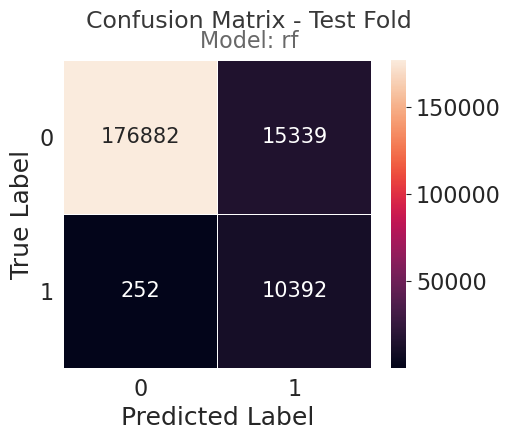

In [72]:
l_train_error = list()

for m_name, d_gs in d_search_fit.items():
    y_pred_ = d_gs.predict(X_train)
    y_true_ = y_train
    print(f"=== {m_name} ===")
    print(d_gs.best_estimator_)
#     try:
    print(classification_report(y_true_, y_pred=y_pred_, digits=3))
    accuracy_ = accuracy_score(y_true_, y_pred=y_pred_)
        
#     except ValueError:
#         y_pred_ = le.inverse_transform(y_pred_)
#         print(classification_report(y_test, y_pred=y_pred_, labels=le.classes_, digits=3))
#         accuracy_ = accuracy_score(y_test, y_pred=y_pred_)
        
    # save error dataframe
    l_train_error.append(
        {
            'model_name': m_name,
            'error': 1 - accuracy_,
            'accuracy': accuracy_,
            'model_class': str(type(d_gs.best_estimator_['clf'])).split('.')[-1][:-2],
            'model_params': str(d_gs.best_estimator_['clf']).replace('\n', ' '),
        }
    )
    
    # confusion matrix
    conf_mx = confusion_matrix(y_true=y_true_, y_pred=y_pred_, labels=le.classes_)
    mask_exclude = conf_mx == 0
    with sns.axes_style("white"):
        plt.figure(figsize=(5, 4))

        ax = sns.heatmap(
            conf_mx,
            # center=0,
            # cmap=cm.PiYG,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot=True,
            annot_kws={"size": 15},
            mask=mask_exclude,
            square=True,
            fmt="0.0f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        # plt.xticks(rotation=45)
        ax.set(
            ylabel='True Label',
            xlabel='Predicted Label',
        )

        plt.figtext(
            .5, .96, f"Confusion Matrix - Test Fold",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .91, f"Model: {m_name}",
            fontsize=16, color='#686868', ha='center'
        )
        plt.show()


=== rf ===
              precision    recall  f1-score   support

           0      0.978     0.866     0.919     48135
           1      0.205     0.644     0.312      2582

    accuracy                          0.855     50717
   macro avg      0.592     0.755     0.615     50717
weighted avg      0.939     0.855     0.888     50717



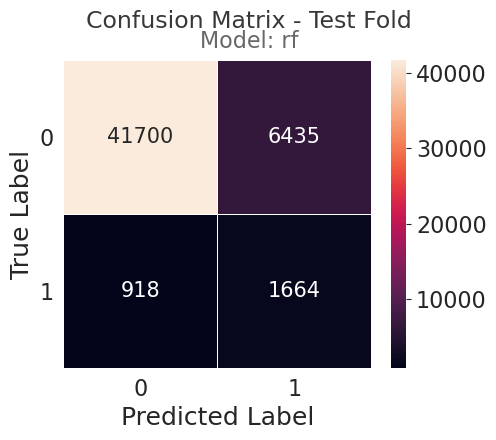

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"42,618",84.0%,84.0%
1,"8,099",16.0%,100.0%


In [63]:
l_test_error = list()

for m_name, d_gs in d_search_fit.items():
    y_pred_ = d_gs.predict(X_test)
    print(f"=== {m_name} ===")
#     try:
    print(classification_report(y_test, y_pred=y_pred_, digits=3))
    accuracy_ = accuracy_score(y_test, y_pred=y_pred_)
        
#     except ValueError:
#         y_pred_ = le.inverse_transform(y_pred_)
#         print(classification_report(y_test, y_pred=y_pred_, labels=le.classes_, digits=3))
#         accuracy_ = accuracy_score(y_test, y_pred=y_pred_)
        
    # save error dataframe
    l_test_error.append(
        {
            'model_name': m_name,
            'error': 1 - accuracy_,
            'accuracy': accuracy_,
            'model_class': str(type(d_gs.best_estimator_['clf'])).split('.')[-1][:-2],
            'model_params': str(d_gs.best_estimator_['clf']).replace('\n', ' '),
        }
    )
    
    # confusion matrix
    conf_mx = confusion_matrix(y_true=y_test, y_pred=y_pred_, labels=le.classes_)
    mask_exclude = conf_mx == 0
    with sns.axes_style("white"):
        plt.figure(figsize=(5, 4))

        ax = sns.heatmap(
            conf_mx,
            # center=0,
            # cmap=cm.PiYG,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot=True,
            annot_kws={"size": 15},
            mask=mask_exclude,
            square=True,
            fmt="0.0f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        # plt.xticks(rotation=45)
        ax.set(
            ylabel='True Label',
            xlabel='Predicted Label',
        )

        plt.figtext(
            .5, .96, f"Confusion Matrix - Test Fold",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .91, f"Model: {m_name}",
            fontsize=16, color='#686868', ha='center'
        )
        plt.show()
    display(
        value_counts_and_pcts(
            pd.Series(y_pred_, name='pred').to_frame(),
            'pred',
        )
    )

=== rf ===
              precision    recall  f1-score   support

           0      0.973     0.906     0.938     48135
           1      0.231     0.525     0.321      2582

    accuracy                          0.887     50717
   macro avg      0.602     0.716     0.630     50717
weighted avg      0.935     0.887     0.907     50717



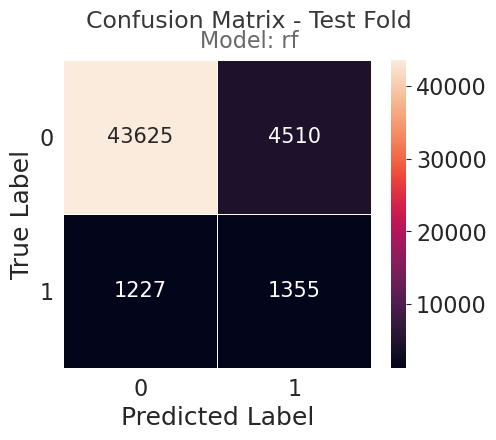

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"44,852",88.4%,88.4%
1,"5,865",11.6%,100.0%


In [73]:
l_test_error = list()

for m_name, d_gs in d_search_fit.items():
    y_pred_ = d_gs.predict(X_test)
    print(f"=== {m_name} ===")
#     try:
    print(classification_report(y_test, y_pred=y_pred_, digits=3))
    accuracy_ = accuracy_score(y_test, y_pred=y_pred_)
        
#     except ValueError:
#         y_pred_ = le.inverse_transform(y_pred_)
#         print(classification_report(y_test, y_pred=y_pred_, labels=le.classes_, digits=3))
#         accuracy_ = accuracy_score(y_test, y_pred=y_pred_)
        
    # save error dataframe
    l_test_error.append(
        {
            'model_name': m_name,
            'error': 1 - accuracy_,
            'accuracy': accuracy_,
            'model_class': str(type(d_gs.best_estimator_['clf'])).split('.')[-1][:-2],
            'model_params': str(d_gs.best_estimator_['clf']).replace('\n', ' '),
        }
    )
    
    # confusion matrix
    conf_mx = confusion_matrix(y_true=y_test, y_pred=y_pred_, labels=le.classes_)
    mask_exclude = conf_mx == 0
    with sns.axes_style("white"):
        plt.figure(figsize=(5, 4))

        ax = sns.heatmap(
            conf_mx,
            # center=0,
            # cmap=cm.PiYG,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot=True,
            annot_kws={"size": 15},
            mask=mask_exclude,
            square=True,
            fmt="0.0f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        # plt.xticks(rotation=45)
        ax.set(
            ylabel='True Label',
            xlabel='Predicted Label',
        )

        plt.figtext(
            .5, .96, f"Confusion Matrix - Test Fold",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .91, f"Model: {m_name}",
            fontsize=16, color='#686868', ha='center'
        )
        plt.show()
    display(
        value_counts_and_pcts(
            pd.Series(y_pred_, name='pred').to_frame(),
            'pred',
        )
    )

# Get feature importance
Might help us better select which columns to use for additional stratification

In [99]:
df_importances = (
    pd.DataFrame(
        {
            'feature_names': X_train.columns,
            'importances': d_search_fit['rf'].best_estimator_['clf'].feature_importances_,
            'std': np.std([tree.feature_importances_ for tree in d_search_fit['rf'].best_estimator_['clf'].estimators_], axis=0),
        }
    )
    .sort_values(by=['importances'], ascending=False)
)
df_importances.head(10)

,feature_names,importances,std
2,user_clicks_pn_t7,0.263695,0.117925
3,user_clicks_trnd_t7,0.136367,0.102518
1,user_receives_pn_t7,0.088754,0.017442
4,screen_view_count_14d,0.061352,0.063572
6,num_post_consumes_home,0.048550,0.024171
19,cosine_similarity,0.046160,0.014457
12,pct_post_consumes_nsfw,0.038292,0.008819
5,num_post_consumes,0.037014,0.011349
0,tos_sub_count,0.036990,0.013565
7,num_post_consumes_community,0.035378,0.010035


## Impurity-based feature importances

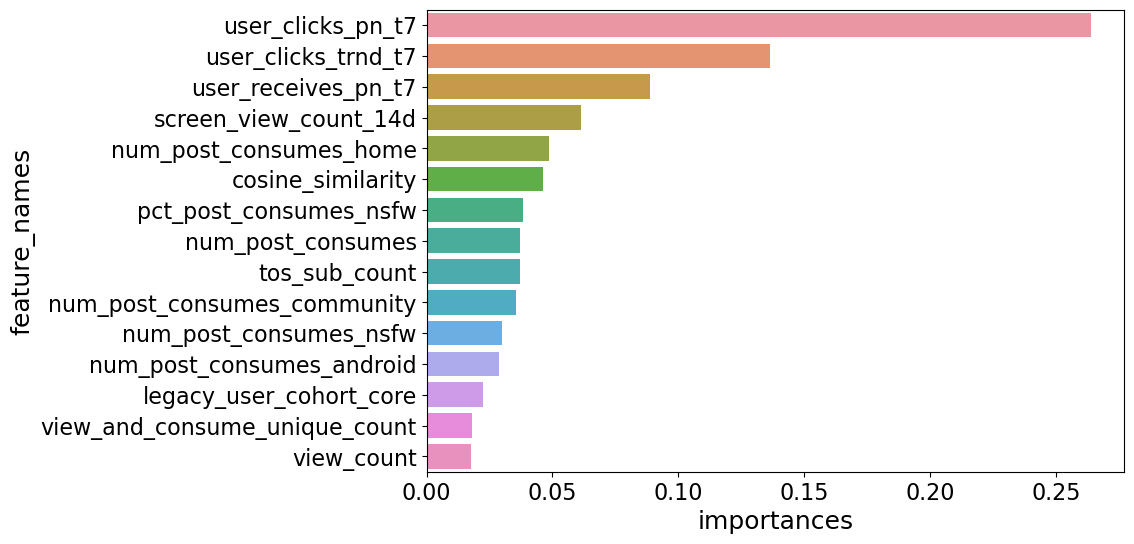

In [106]:
ax = sns.barplot(
    data=df_importances.head(15),
    x='importances',
    y='feature_names',
)

<BarContainer object of 15 artists>

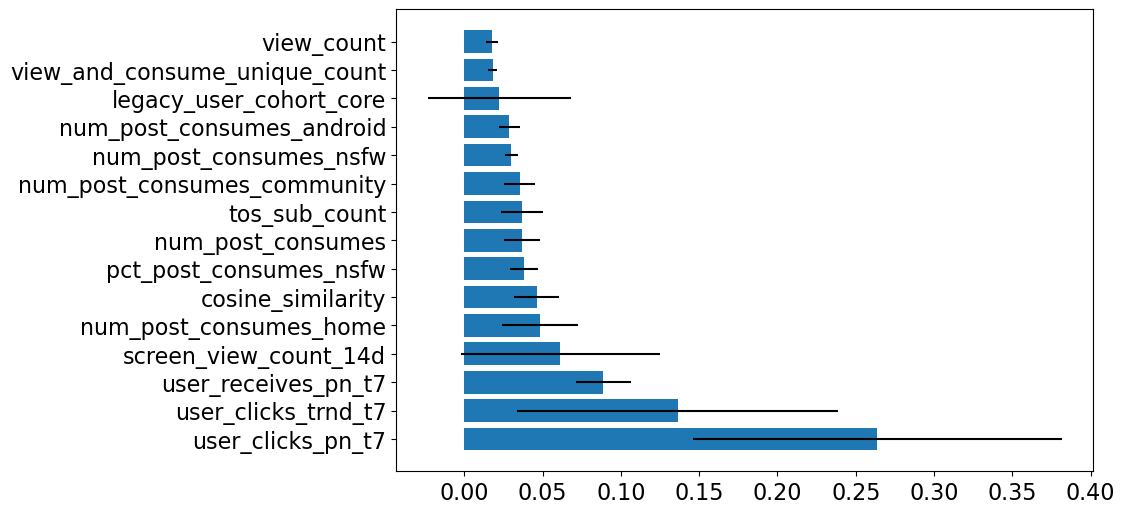

In [128]:

plt.barh(
    y=df_importances.head(15)['feature_names'],
    width=df_importances.head(15)['importances'],
    xerr=df_importances.head(15)['std'],
)

## Importance based on feature permutation
This is EXPENSIVE because we need to shuffle features AND refit a model N times.

In [130]:
# TODO
from sklearn.inspection import permutation_importance

In [131]:
%%time

perm_importance = permutation_importance(
    d_search_fit['rf'].best_estimator_['clf'],
    X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

CPU times: user 42.2 s, sys: 31.3 s, total: 1min 13s
Wall time: 1min 20s


In [132]:
df_importances_p = (
    pd.DataFrame(
        {
            'feature_names': X_train.columns,
            'importances': perm_importance.importances_mean,
            'std': perm_importance.importances_std,
        }
    )
    .sort_values(by=['importances'], ascending=False)
)
df_importances_p.head(10)

,feature_names,importances,std
8,num_post_consumes_post_detail,0.000270,0.000145
23,legacy_user_cohort_new,0.000000,0.000000
24,legacy_user_cohort_resurrected,-0.000006,0.000013
21,legacy_user_cohort_casual,-0.000132,0.000077
17,consume_ios_count,-0.001431,0.000097
9,num_post_consumes_ios,-0.002382,0.000184
18,consume_android_count,-0.005272,0.000298
15,view_count,-0.006136,0.000269
13,view_and_consume_unique_count,-0.006992,0.000283
2,user_clicks_pn_t7,-0.007228,0.000533


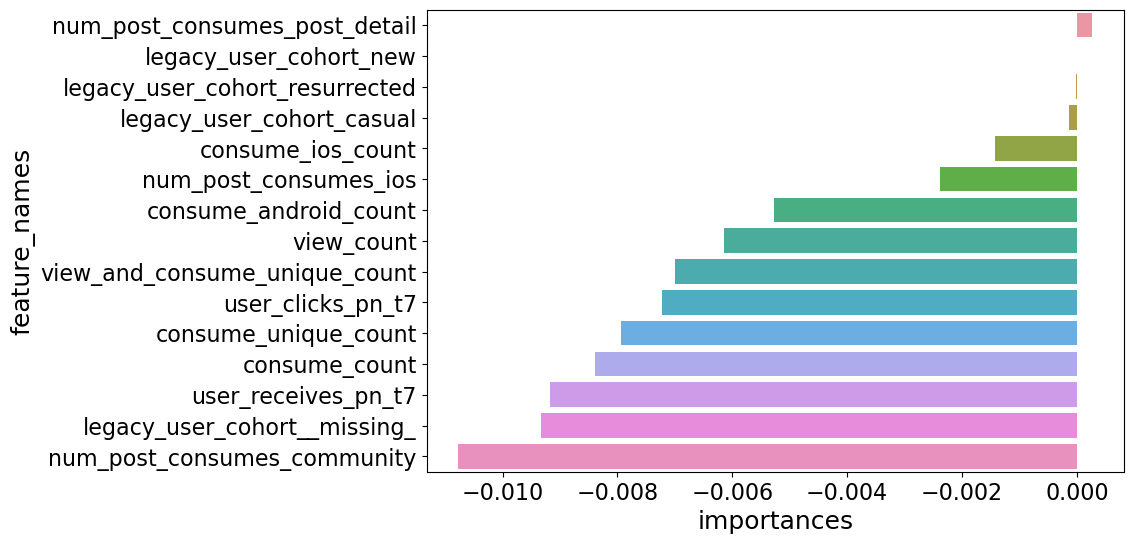

In [134]:
ax = sns.barplot(
    data=df_importances_p.head(15),
    x='importances',
    y='feature_names',
)

<BarContainer object of 15 artists>

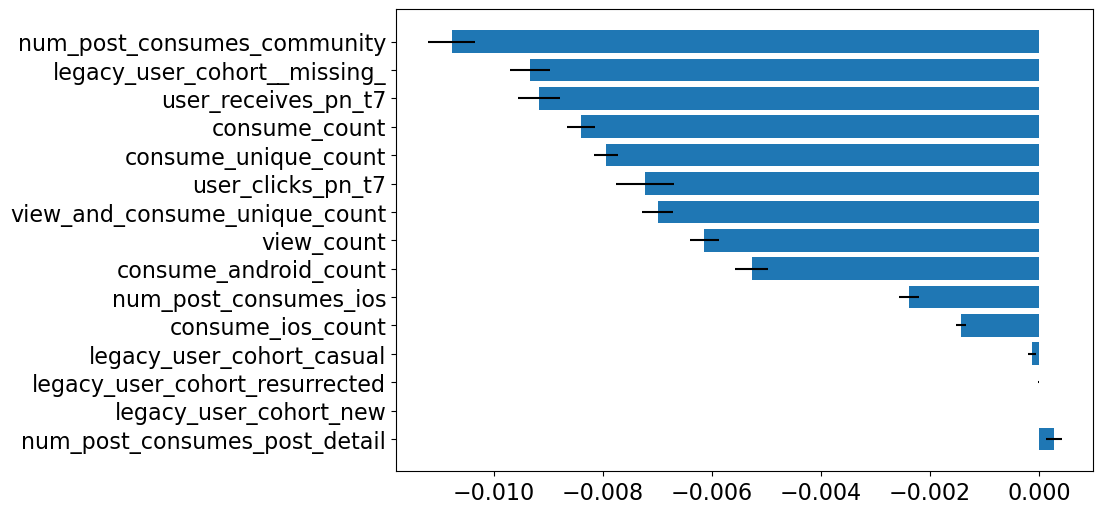

In [136]:

plt.barh(
    y=df_importances_p.head(15)['feature_names'],
    width=df_importances_p.head(15)['importances'],
    xerr=df_importances_p.head(15)['std'],
)

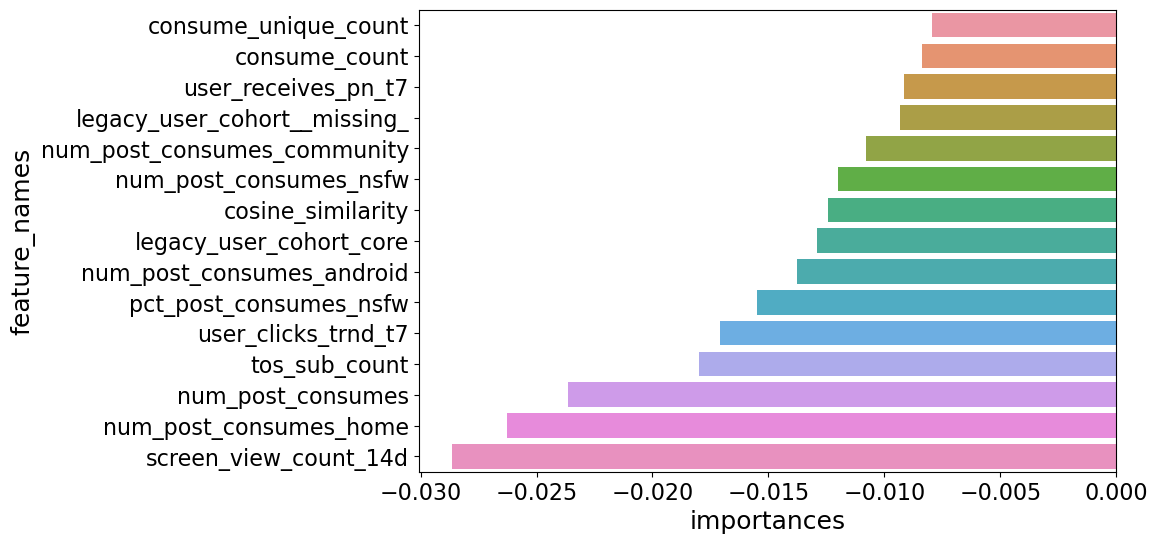

In [135]:
ax = sns.barplot(
    data=df_importances_p.tail(15),
    x='importances',
    y='feature_names',
)

In [133]:
df_importances_p.tail(10)

,feature_names,importances,std
11,num_post_consumes_nsfw,-0.011976,0.000339
19,cosine_similarity,-0.012418,0.000458
22,legacy_user_cohort_core,-0.012883,0.000493
10,num_post_consumes_android,-0.013767,0.000315
12,pct_post_consumes_nsfw,-0.015502,0.000485
3,user_clicks_trnd_t7,-0.017099,0.000479
0,tos_sub_count,-0.017990,0.000472
5,num_post_consumes,-0.023665,0.000445
6,num_post_consumes_home,-0.026285,0.000591
4,screen_view_count_14d,-0.028653,0.000803


# Can we get a bette prediction by lowering the proba threshold?

In [74]:
d_search_fit['rf'].classes_

array([0, 1])

In [75]:
d_search_fit['rf'].best_params_

{'clf__criterion': 'gini',
 'clf__max_depth': 18,
 'clf__min_samples_leaf': 2,
 'clf__n_estimators': 1000}

In [76]:
d_search_fit['rf'].best_estimator_

Pipeline(steps=[('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=18,
                                        min_samples_leaf=2, n_estimators=1000,
                                        n_jobs=-1, random_state=42))])

In [77]:
df_y_test = pd.DataFrame(
    {
        'y_test': y_test,
        'y_pred_proba': d_search_fit['rf'].predict_proba(X_test)[:, 1],
    }
)

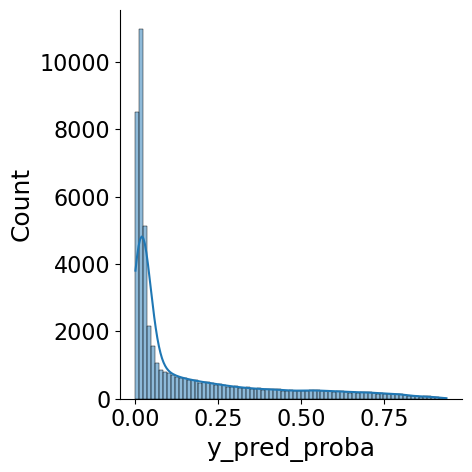

In [78]:
sns.displot(data=df_y_test, x="y_pred_proba", kde=True);

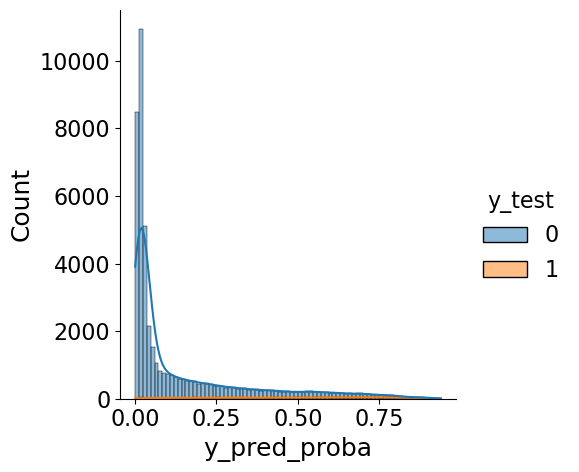

In [79]:
sns.displot(data=df_y_test, x="y_pred_proba", kde=True, hue='y_test')


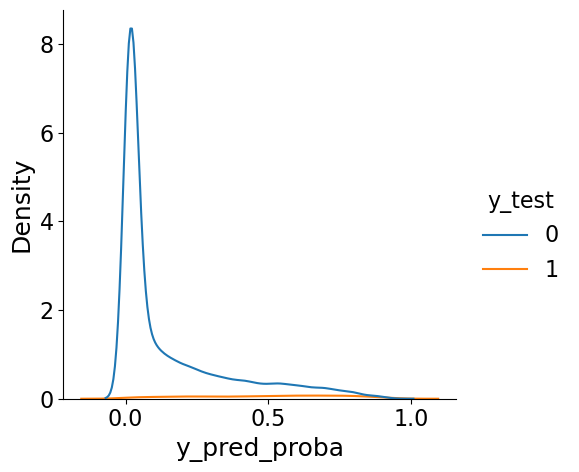

In [80]:
sns.displot(data=df_y_test, x="y_pred_proba", kind='kde', hue='y_test')


In [ ]:
# fig = px.histogram(
#     df_y_test, x="y_pred_proba", y="y_test", color="sex",
#     marginal="box", # or violin, rug
#     hover_data=df.columns
# )
# fig.show()

In [ ]:
# TODO: create pipeline with SCALED numeric values
#. it's possible the model will be more robust if we apply scaling
#. it could also make feature importance more readable

In [82]:
# !pip list